In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import neighbors
from sklearn.metrics import recall_score, classification_report
wine = pd.read_csv('../datasets/wine.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Data

In [2]:
wine.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [3]:
X = wine.drop('quality', axis=1)
y = wine['quality']

In [4]:
X = X[(y == 3) | (y == 5) | (y == 8)]
y = y[(y == 3) | (y == 5) | (y == 8)]
X = X[['residual sugar', 'alcohol']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=23)

In [6]:
n_neighbors = 15
h = 0.02
X_train = X_train.values
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

0.961267605634
0.947183098592


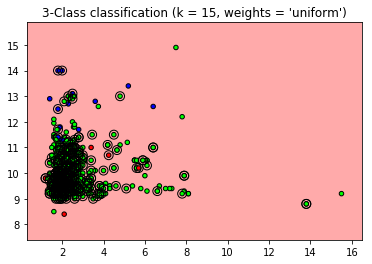

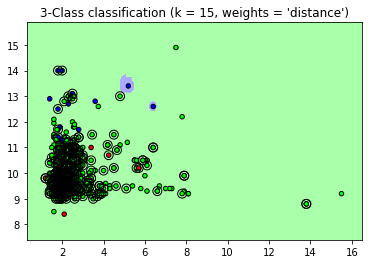

In [7]:
# Courtesy of http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
for weights in ['uniform', 'distance']:
    # Create instance of Neighbours Classifier
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_train, y_train)
    
    accur = clf.score(X_test, y_test)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X.values[:, 0], X.values[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    # Circle out the test data
    plt.scatter(X_test.values[:, 0], X_test.values[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
    
    print accur

plt.show()

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 1, 'algorithm': 'ball_tree', 'p': 2}

Grid scores on development set:
Detailed classification report:
             precision    recall  f1-score   support

          3       0.00      0.00      0.00        10
          5       0.96      1.00      0.98       681
          8       1.00      0.11      0.20        18

avg / total       0.95      0.96      0.95       709



/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


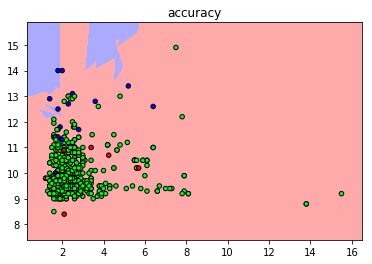

# Tuning hyper-parameters for precision_macro


/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 1, 'algorithm': 'brute', 'p': 2}

Grid scores on development set:
Detailed classification report:
             precision    recall  f1-score   support

          3       0.73      0.80      0.76        10
          5       0.99      1.00      0.99       681
          8       1.00      0.72      0.84        18

avg / total       0.99      0.99      0.99       709



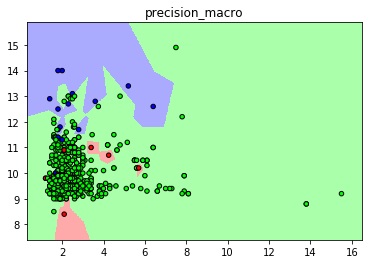

# Tuning hyper-parameters for recall_macro
Best parameters set found on development set:
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 1, 'algorithm': 'brute', 'p': 2}

Grid scores on development set:
Detailed classification report:
             precision    recall  f1-score   support

          3       0.73      0.80      0.76        10
          5       0.99      1.00      0.99       681
          8       1.00      0.72      0.84        18

avg / total       0.99      0.99      0.99       709



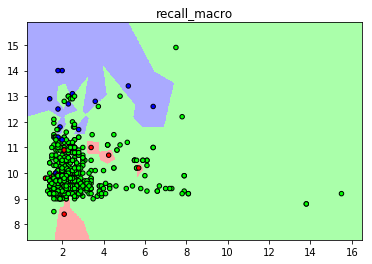

In [8]:
# Now to grid search for a really good model
tuned_parameters = [{'weights': ['uniform', 'distance'],
                     'n_neighbors': range(1,20, 2),
                     'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                     'leaf_size': range(1,30,2),
                     'p': [1,2,5,10]}]

scores = ['accuracy', 'precision_macro', 'recall_macro']
for fig_num, score in enumerate(scores):
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))

    print("Detailed classification report:")
    y_true, y_pred = y, clf.predict(X)

    plt.clf()
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X.values[:, 0], X.values[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(score)
    print(classification_report(y_true, y_pred))
    plt.show()

### Two Classes (quality 3 and 8)

In [9]:
X = wine.drop('quality', axis=1)
y = wine['quality']

In [10]:
X = X[(y == 3) | (y == 8)]
y = y[(y == 3) | (y == 8)]
X = X[['residual sugar', 'alcohol']]
print X.shape
print y.shape

(28, 2)
(28,)


In [11]:
h = 0.02
X = X.values
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 1, 'algorithm': 'ball_tree', 'p': 1}

Grid scores on development set:
Detailed classification report:
             precision    recall  f1-score   support

          3       0.80      0.80      0.80        10
          8       0.89      0.89      0.89        18

avg / total       0.86      0.86      0.86        28



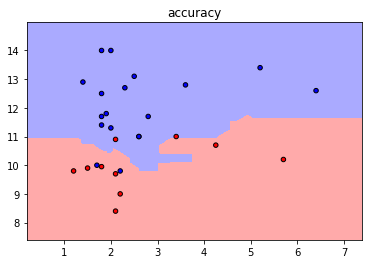

# Tuning hyper-parameters for precision_macro
Best parameters set found on development set:
{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 1, 'algorithm': 'ball_tree', 'p': 1}

Grid scores on development set:
Detailed classification report:
             precision    recall  f1-score   support

          3       1.00      1.00      1.00        10
          8       1.00      1.00      1.00        18

avg / total       1.00      1.00      1.00        28



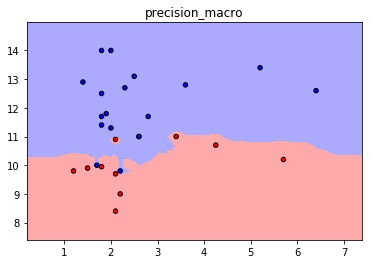

# Tuning hyper-parameters for recall_macro
Best parameters set found on development set:
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 1, 'algorithm': 'ball_tree', 'p': 1}

Grid scores on development set:
Detailed classification report:
             precision    recall  f1-score   support

          3       0.80      0.80      0.80        10
          8       0.89      0.89      0.89        18

avg / total       0.86      0.86      0.86        28



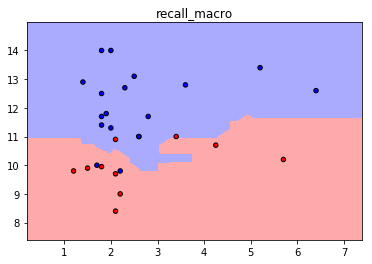

In [12]:
# Now to grid search for a really good model
tuned_parameters = [{'weights': ['uniform', 'distance'],
                     'n_neighbors': range(1,20, 2),
                     'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                     'leaf_size': range(1,30,2),
                     'p': [1,2,5,10]}]

scores = ['accuracy', 'precision_macro', 'recall_macro']
for fig_num, score in enumerate(scores):
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))

    print("Detailed classification report:")
    y_true, y_pred = y, clf.predict(X)

    plt.clf()
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(score)
    print(classification_report(y_true, y_pred))
    plt.show()